In [1]:
import asyncio
import time
from typing import get_args

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bcs import BCSz
from bcs.BCSz import MotorStatus

from api_dev.types import AI, DIO, Motor

ai = get_args(AI.__value__)
motor = get_args(Motor.__value__)

## Instancing the RSoXS Server


In [2]:
rsoxs = BCSz.BCSServer()
_ = await rsoxs.connect(addr="localhost", port=5577)

Server Public Key b'W3qN&/Oge>.K)P7rD?BqD^Qf={}1$!++?{*a2:^s'


In [ ]:
from tqdm.auto import tqdm


def calculate_channel_statistics(ai_result: dict, motor_result: dict) -> pd.DataFrame:
    """
    Calculate statistics for all AI channels and combine with motor positions.

    Parameters:
        ai_result: Result from get_acquired_array() containing AI channel data
        motor_result: Result from get_motor() containing motor positions

    Returns:
        DataFrame with one row containing mean and std for all channels
    """
    stats = {}

    # Process AI channels
    for chan_data in ai_result.get("chans", []):
        chan_name = chan_data["chan"].replace(" ", "_").lower()
        data = np.array(chan_data.get("data", []), dtype=float)

        if len(data) > 0:
            stats[f"{chan_name}_all"] = data.tolist()
            stats[f"{chan_name}_mean"] = np.nanmean(data)
            stats[f"{chan_name}_std"] = np.nanstd(data) / np.sqrt(len(data))
        else:
            stats[f"{chan_name}_all"] = [data]
            stats[f"{chan_name}_mean"] = np.nan
            stats[f"{chan_name}_std"] = np.nan

    # Process motor positions
    for motor_data in motor_result.get("data", []):
        motor_name = motor_data["motor"]
        position = motor_data["position"]
        stats[f"{motor_name}_position"] = position

    # Return as single-row DataFrame
    return pd.DataFrame([stats])


async def wait_for_motor_completion(
    server: BCSz.BCSServer, motor: Motor, timeout: float = 30.0
) -> bool:
    """
    Wait for motor to complete its movement by checking status.

    Parameters:
        server: BCS server instance
        motor: Motor name to check
        timeout: Maximum time to wait in seconds

    Returns:
        True if move completed, False if timeout occurred
    """
    start_time = time.time()

    while (time.time() - start_time) < timeout:
        await asyncio.sleep(0.1)
        motor_data = await server.get_motor(motors=[motor])
        motor_info = motor_data["data"][0]
        status = MotorStatus(motor_info["status"])

        # Check if move is complete
        if status.is_set(MotorStatus.MOVE_COMPLETE):
            return True

        # Small delay to avoid hammering the API

    print(f"Warning: Motor {motor} move timeout after {timeout}s")
    return False





async def collect_data_at_position(
    server: BCSz.BCSServer,
    motor: Motor,
    position: float,
    count_time_s: float,
    delay_after_move_s: float = 0.5,
    shutter: DIO = "Shutter Output",
    motor_timeout: float = 30.0,
    ai_channels: list[AI] = None,
    motor_channels: list[Motor] = None,
) -> pd.DataFrame:
    """
    Complete data collection sequence with proper delay handling.

    Steps:
    1. Moves motor to position with backlash compensation
    2. Waits for motor to complete movement
    3. Delays for specified settling time
    4. Opens shutter
    5. Collects data for specified time
    6. Closes shutter
    7. Returns collected data as DataFrame

    Parameters:
        server: BCS server instance
        motor: Motor name to move
        position: Target position
        count_time_s: Data collection time in seconds
        delay_after_move_s: Settling time after motor movement
        shutter: Shutter channel name
        motor_timeout: Maximum time to wait for motor completion
        ai_channels: List of AI channels to read (None = all)
        motor_channels: List of motors to read positions (None = all)

    Returns:
        DataFrame with one row containing statistics for all channels
    """
    # 1. Move motor to position with backlash compensation
    await server.command_motor(
        commands=["Backlash Move"], motors=[motor], goals=[position]
    )

    # 2. Wait for motor move completion
    move_complete = await wait_for_motor_completion(server, motor, motor_timeout)
    if not move_complete:
        print(f"Warning: Motor {motor} may not have reached position {position}")

    # 3. Add delay for motor settling
    if delay_after_move_s > 0:
        await asyncio.sleep(delay_after_move_s)

    try:
        # 4. Open shutter
        await server.set_do(chan=shutter, value=True)

        # 5. Collect data
        await server.acquire_data(time=count_time_s, counts=0)

        # 6. Get results
        ai_chans = list(get_args(AI.__value__)) if ai_channels is None else ai_channels
        motor_chans = (
            list(get_args(Motor.__value__))
            if motor_channels is None
            else motor_channels
        )

        r_ai = await server.get_acquired_array(chans=ai_chans)
        r_motor = await server.get_motor(motors=motor_chans)

        # Calculate statistics and return as DataFrame
        return calculate_channel_statistics(r_ai, r_motor)

    finally:
        # 7. Always close shutter, even if an error occurs
        await server.set_do(chan=shutter, value=False)


async def scan_motor_from_list(
    server: BCSz.BCSServer,
    motor: list[Motor] | Motor,
    positions: list[float],
    count_time_s: list[float],
    *,
    delay_after_move_s: float = 0.5,
    leave_open=False,
    shutter: DIO = "Shutter Output",
    motor_timeout: float = 30.0,
    ai_channels: list[AI] = None,
    motor_channels: list[Motor] = None,
) -> pd.DataFrame:
    """
    Run a single motor scan from a given position list.

    Parameters:
        server: BCS server instance
        motor: Motor name to scan
        positions: List of positions to visit
        count_time_s: Data collection time at each position
        delay_after_move_s: Settling time after each motor movement
        shutter: Shutter channel name
        motor_timeout: Maximum time to wait for motor completion
        ai_channels: List of AI channels to read (None = all)
        motor_channels: List of motors to read positions (None = all)

    Returns:
        DataFrame with one row per position containing all channel statistics
    """
    data_frames = []
    if isinstance(motor, str):
        motor = [motor] * len(positions)

    if isinstance(count_time_s, float):
        count_time_s = [count_time_s] * len(positions)
    if leave_open:
        #  TODO: add open the shutters now and close on finally
        ...
    print(len(positions), len(count_time_s), len(motor))
    for i, (pos, mot, exp) in enumerate(
        tqdm(zip(positions, motor, count_time_s), desc=f"Scanning {motor}", unit="pos")
    ):
        print(f"Moving {mot} to position {pos} with exposure {exp}s")
        df = await collect_data_at_position(
            server=server,
            motor=mot,
            position=pos,
            count_time_s=exp,
            delay_after_move_s=delay_after_move_s,
            shutter=shutter,
            motor_timeout=motor_timeout if i != 0 else motor_timeout * 2,
            ai_channels=ai_channels,
            motor_channels=motor_channels,
        )
        df["exposure"] = exp
        data_frames.append(df)

    # Combine all rows into single DataFrame
    return pd.concat(data_frames, ignore_index=True)

In [62]:
# #  Check driver status
# status = await rsoxs.get_instrument_driver_status(name="CCD")
# status

In [63]:
# await rsoxs.start_instrument_acquire(name="CCD", acq_time_s=0.1)
# img = await rsoxs.get_instrument_acquired2d(name="CCD")

In [64]:
# plt.imshow(np.array(img["data"]), cmap="gray")

In [35]:
default_energies = np.loadtxt("data/c-kedge.txt")
# Random x-array
default_energies = np.linspace(10, 20, 100)

In [36]:
# var = await rsoxs.list_state_variables()
# var

In [37]:
# await rsoxs.set_state_variable(name="Camera ROI X", value=800)

In [45]:
scan_single = await collect_data_at_position(
    server=rsoxs,
    motor="Sample X",
    position=default_energies[0],
    count_time_s=1,
    delay_after_move_s=0.2,
    shutter="Light Output",
)
scan_single

[{'motor': 'Sample X', 'position': 10.0, 'position_raw': -20000.0, 'goal': 10.0, 'goal_raw': -20000.0, 'status': 65560, 'time': 3845049451.61851}]
[{'motor': 'Sample X', 'position': 10.0, 'position_raw': -20000.0, 'goal': 10.0, 'goal_raw': -20000.0, 'status': 24, 'time': 3845049451.78051}]
[{'motor': 'Sample X', 'position': 10.0, 'position_raw': -20000.0, 'goal': 10.0, 'goal_raw': -20000.0, 'status': 24, 'time': 3845049451.86151}]
[{'motor': 'Sample X', 'position': 10.0, 'position_raw': -20000.0, 'goal': 10.0, 'goal_raw': -20000.0, 'status': 65560, 'time': 3845049452.02451}]
[{'motor': 'Sample X', 'position': 10.0, 'position_raw': -20000.0, 'goal': 10.0, 'goal_raw': -20000.0, 'status': 24, 'time': 3845049452.10451}]
[{'motor': 'Sample X', 'position': 10.0, 'position_raw': -20000.0, 'goal': 10.0, 'goal_raw': -20000.0, 'status': 24, 'time': 3845049452.18651}]
[{'motor': 'Sample X', 'position': 10.0, 'position_raw': -20000.0, 'goal': 10.0, 'goal_raw': -20000.0, 'status': 8, 'time': 384504

tey_signal_all  tey_signal_mean  \
0  [-0.00231708575700014, -0.00136370686088325, -...        -0.001677   

   tey_signal_std                                          izero_all  \
0        0.000017  [-0.26787122341716, 0.00827990554469943, -0.21...   

   izero_mean  izero_std                                     photodiode_all  \
0   -0.121845   0.002797  [173.53211808941, 172.5458624512, 171.52673164...   

   photodiode_mean  photodiode_std  \
0       172.471745        0.019643   

                                            ai_0_all  ...  \
0  [-0.435437307233324, -0.445299849586249, -0.46...  ...   

   Camera ROI Y_position  Camera ROI Width_position  \
0                    0.0                     2048.0   

  Camera ROI Height_position  Camera ROI X Bin_position  \
0                     2048.0                        2.0   

   Camera ROI Y Bin_position SampleRot0_position  SampleRot1_position  \
0                        2.0                 0.0                  0.0   

   SampleRot2_position SampleRot3_position  SampleRot4_position  
0                  0.0                 0.0                  0.0  

[1 rows x 148 columns]

2000

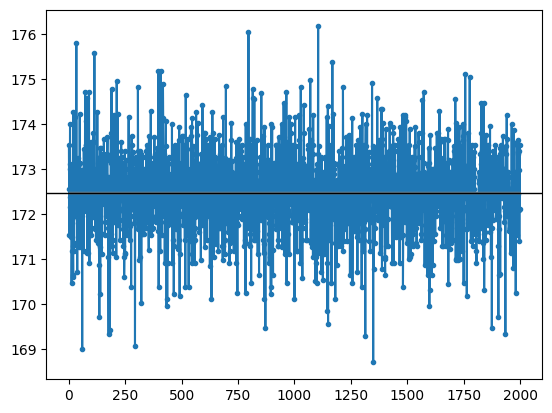

In [57]:
plt.plot(scan_single["photodiode_all"][0], marker=".")
plt.axhline(scan_single["photodiode_mean"][0], color="k", lw=1, zorder=10)
plt.fill_between(
    x=np.arange(len(scan_single["photodiode_all"][0])),
    y1=scan_single["photodiode_mean"][0]
    - scan_single["photodiode_std"][0],  # * np.sqrt(2000),
    y2=scan_single["photodiode_mean"][0]
    + scan_single["photodiode_std"][0],  # * np.sqrt(2000),
    color="gray",
    alpha=0.5,
    zorder=5,
)
len(scan_single["photodiode_all"][0])

In [29]:
default_energies[:10]

array([10.        , 10.1010101 , 10.2020202 , 10.3030303 , 10.4040404 ,
       10.50505051, 10.60606061, 10.70707071, 10.80808081, 10.90909091])

In [78]:
scan_data = await scan_motor_from_list(
    server=rsoxs,
    motor="Sample X",
    positions=default_energies[:10],  # First 10 energies for testing
    count_time_s=1.0,
    delay_after_move_s=0.2,
    shutter="Light Output",
)
scan_data

10 10 10


Scanning ['Sample X', 'Sample X', 'Sample X', 'Sample X', 'Sample X', 'Sample X', 'Sample X', 'Sample X', 'Sam…

Moving Sample X to position 10.0 with exposure 1.0s
Moving Sample X to position 10.1010101010101 with exposure 1.0s
Moving Sample X to position 10.202020202020202 with exposure 1.0s
Moving Sample X to position 10.303030303030303 with exposure 1.0s
Moving Sample X to position 10.404040404040405 with exposure 1.0s
Moving Sample X to position 10.505050505050505 with exposure 1.0s
Moving Sample X to position 10.606060606060606 with exposure 1.0s
Moving Sample X to position 10.707070707070708 with exposure 1.0s
Moving Sample X to position 10.808080808080808 with exposure 1.0s
Moving Sample X to position 10.909090909090908 with exposure 1.0s


tey_signal_all  tey_signal_mean  \
0  [-0.00136370686088325, -0.00228421062269381, -...        -0.001743   
1  [-0.00129795659209055, -0.00218558521975673, -...        -0.001690   
2  [-0.00373071652935852, -0.000870579844635418, ...        -0.001693   
3  [-0.00165958307029788, -0.00139658199527497, -...        -0.001726   
4  [-0.00162670793593077, -0.00188970901078201, -...        -0.001712   
5  [-0.00221846035407211, -0.000936330113508926, ...        -0.001718   
6  [-0.00195545927946432, -0.00152808253281103, -...        -0.001746   
7  [-0.0011007057856381, -0.00287596303974916, -0...        -0.001724   
8  [-0.00103495551679578, -0.0028102127712352, -0...        -0.001742   
9  [-0.00228421062269381, -0.000903454979073734, ...        -0.001709   

   tey_signal_std                                          izero_all  \
0        0.000017  [-0.0837704710193973, 0.0740301746725167, 0.04...   
1        0.000016  [-0.0443203096651727, -0.234996089130346, -0.1...   
2        0.000017  [-0.11007057856381, 0.0312924997247482, -0.011...   
3        0.000017  [-0.175820847338084, -0.234996089130346, -0.18...   
4        0.000017  [-0.0245952289710144, -0.376359166353485, -0.1...   
5        0.000018  [-0.254721169706028, -0.294171330825125, -0.13...   
6        0.000016  [0.0411550400924551, -0.261296196562191, -0.19...   
7        0.000016  [-0.0574703634549507, 0.0937552554361704, -0.0...   
8        0.000017  [-0.116645605446799, -0.162670793593077, 0.001...   
9        0.000016  [-0.304033871098219, -0.471697055339967, -0.17...   

   izero_mean  izero_std                                     photodiode_all  \
0   -0.119519   0.002625  [173.07186545633, 173.00611508045, 173.7951195...   
1   -0.122645   0.002722  [171.033603835741, 172.611612826603, 171.23085...   
2   -0.123564   0.002698  [172.808863953219, 172.808863953219, 172.41436...   
3   -0.117214   0.002770  [172.743113577612, 172.480112075866, 170.90210...   
4   -0.123212   0.002706  [171.822608326275, 172.085609825295, 172.67736...   
5   -0.120632   0.002684  [171.691107577174, 175.504629412176, 173.13761...   
6   -0.123821   0.002705  [172.940364704638, 170.244599354963, 173.00611...   
7   -0.119959   0.002724  [172.743113577612, 173.367742148639, 173.92662...   
8   -0.122954   0.002674  [172.743113577612, 172.677363202073, 172.28286...   
9   -0.123277   0.002729  [170.573351220771, 171.822608326275, 171.42810...   

   photodiode_mean  photodiode_std  \
0       172.636877        0.019532   
1       172.592644        0.019545   
2       172.522554        0.020010   
3       172.519842        0.019986   
4       172.483120        0.019547   
5       172.449012        0.019713   
6       172.453483        0.020076   
7       172.398664        0.020342   
8       172.404335        0.020319   
9       172.376654        0.019218   

                                            ai_0_all  ...  \
0  [-0.456477397659981, -0.475216228432744, -0.50...  ...   
1  [-0.517625162083501, -0.496585070820474, -0.47...  ...   
2  [-0.436094810054969, -0.466339940143848, -0.47...  ...   
3  [-0.419657239593693, -0.416369725521251, -0.41...  ...   
4  [-0.615921842557278, -0.63597568125109, -0.655...  ...   
5  [-0.654385762946909, -0.657015774639277, -0.65...  ...   
6  [-0.467654945813071, -0.452861132098081, -0.43...  ...   
7  [-0.389740861773291, -0.385467093556479, -0.39...  ...   
8  [-0.412095957236853, -0.421300996632376, -0.42...  ...   
9  [-0.635318178338228, -0.645838224984015, -0.62...  ...   

   Camera ROI Width_position  Camera ROI Height_position  \
0                     2048.0                      2048.0   
1                     2048.0                      2048.0   
2                     2048.0                      2048.0   
3                     2048.0                      2048.0   
4                     2048.0                      2048.0   
5                     2048.0                      2048.0   
6                     2048.0                      2048.0   


In [79]:
scan_data["Sample X_position"]

0    10.000
1    10.101
2    10.202
3    10.303
4    10.404
5    10.505
6    10.606
7    10.707
8    10.808
9    10.909
Name: Sample X_position, dtype: float64

<Axes: xlabel='Sample X_position'>

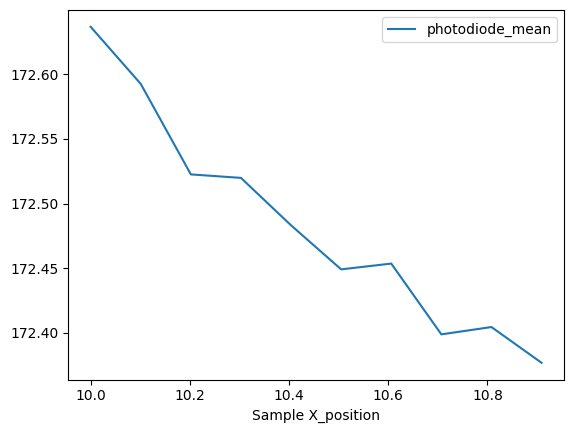

In [80]:
scan_data.plot(x="Sample X_position", y="photodiode_mean")

Scanning Beamline Energy:   0%|          | 0/157 [00:00<?, ?pos/s]

<Axes: xlabel='Beamline Energy_position'>

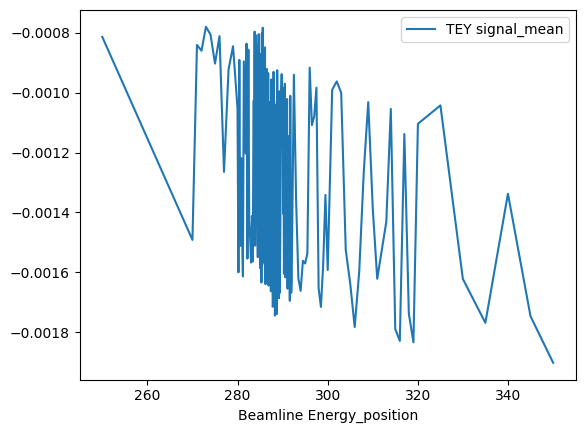

In [ ]:
scan_data = await scan_motor_from_list(
    server=rsoxs,
    motor="Beamline Energy",
    positions=default_energies,  # First 10 energies for testing
    count_time_s=1.0,
    delay_after_move_s=0.2,
)

<Axes: xlabel='Beamline Energy_position'>

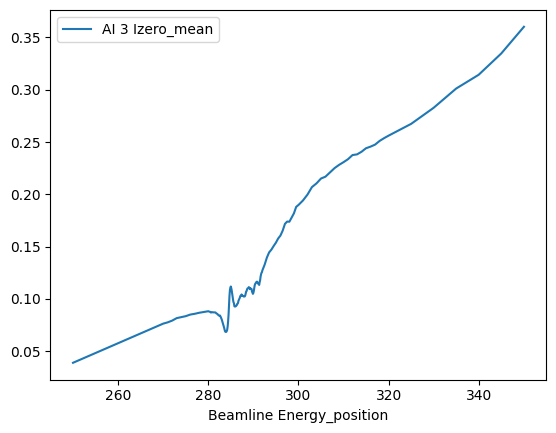

In [18]:
scan_data.plot(x="Beamline Energy_position", y="AI 3 Izero_mean")

<Axes: xlabel='Beamline Energy_position'>

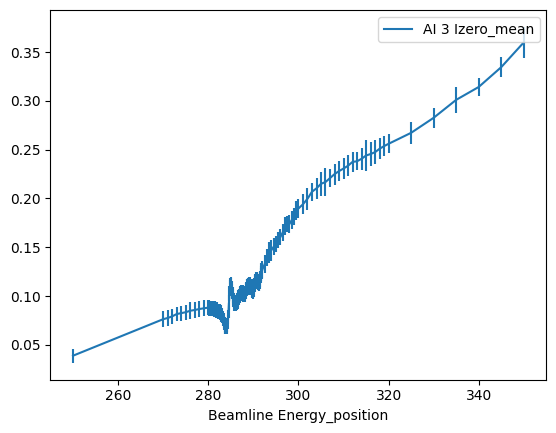

In [19]:
scan_data.plot(x="Beamline Energy_position", y="AI 3 Izero_mean", yerr="AI 3 Izero_std")

In [ ]:
def calculate_nexafs(
    scan_data: pd.DataFrame,
    signal_channel: str = "TEY signal",
    normalization_channel: str = "AI 3 Izero",
) -> pd.DataFrame:
    """
    Calculate NEXAFS absorption spectrum from scan data with error propagation.

    The absorption is calculated as:
        μ = -ln(I/I0)
    where I is the signal channel and I0 is the normalization channel (typically Izero).

    Error propagation for μ = -ln(I/I0):
        σ_μ = sqrt((σ_I/I)^2 + (σ_I0/I0)^2)

    Parameters:
        scan_data: DataFrame containing scan results with mean values for channels
        signal_channel: Name of the signal channel (e.g., "TEY signal", "Photodiode")
        normalization_channel: Name of the normalization channel (e.g., "AI 3 Izero", "Izero")

    Returns:
        DataFrame with energy, absorption, and error columns, filtering out invalid values
    """
    # Column names in the DataFrame
    signal_col = f"{signal_channel}_mean"
    signal_err = f"{signal_channel}_std"
    norm_col = f"{normalization_channel}_mean"
    norm_err = f"{normalization_channel}_std"
    energy_col = "Beamline Energy_position"

    # Check if required columns exist
    required_cols = [signal_col, signal_err, norm_col, norm_err, energy_col]
    missing_cols = [col for col in required_cols if col not in scan_data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Extract data
    energy = scan_data[energy_col].values
    signal = scan_data[signal_col].values
    signal_std = scan_data[signal_err].values
    i0 = scan_data[norm_col].values
    i0_std = scan_data[norm_err].values

    # Calculate transmission (I/I0)
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    transmission = signal / (i0 + epsilon)

    # Calculate absorption: μ = -ln(I/I0)
    # Filter out invalid values (negative, zero, or too close to zero transmission)
    valid_mask = transmission > epsilon

    # Calculate absorption
    absorption = np.zeros_like(transmission)
    absorption[valid_mask] = -np.log(transmission[valid_mask])
    absorption[~valid_mask] = np.nan

    # Error propagation for μ = -ln(I/I0)
    # σ_μ = sqrt((σ_I/I)^2 + (σ_I0/I0)^2)
    absorption_err = np.zeros_like(transmission)
    absorption_err[valid_mask] = np.sqrt(
        (signal_std[valid_mask] / (signal[valid_mask] + epsilon)) ** 2
        + (i0_std[valid_mask] / (i0[valid_mask] + epsilon)) ** 2
    )
    absorption_err[~valid_mask] = np.nan

    # Create result DataFrame
    result = pd.DataFrame(
        {
            "energy": energy,
            "absorption": absorption,
            "absorption_err": absorption_err,
            "transmission": transmission,
            signal_channel: signal,
            f"{signal_channel}_err": signal_std,
            normalization_channel: i0,
            f"{normalization_channel}_err": i0_std,
        }
    )

    # Drop rows with invalid absorption values
    result_clean = result.dropna(subset=["absorption"])

    if len(result_clean) < len(result):
        print(f"Warning: Removed {len(result) - len(result_clean)} invalid data points")

    return result_clean


def plot_nexafs(nexafs_data: pd.DataFrame, title: str = "NEXAFS Spectrum"):
    """
    Plot NEXAFS absorption spectrum with error bars.

    Parameters:
        nexafs_data: DataFrame with 'energy', 'absorption', and optionally 'absorption_err' columns
        title: Plot title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

    # Check if error bars are available
    has_errors = "absorption_err" in nexafs_data.columns

    # Plot absorption
    if has_errors:
        ax1.errorbar(
            nexafs_data["energy"],
            nexafs_data["absorption"],
            yerr=nexafs_data["absorption_err"],
            fmt="o-",
            linewidth=2,
            markersize=4,
            capsize=3,
            capthick=1,
        )
    else:
        ax1.plot(
            nexafs_data["energy"],
            nexafs_data["absorption"],
            "o-",
            linewidth=2,
            markersize=4,
        )
    ax1.set_ylabel("Absorption μ = -ln(I/I₀)")
    ax1.set_title(title)
    ax1.grid(True, alpha=0.4)

    # Plot transmission
    ax2.plot(
        nexafs_data["energy"],
        nexafs_data["transmission"],
        "o-",
        linewidth=2,
        markersize=4,
        color="C1",
    )
    ax2.set_xlabel("Energy (eV)")
    ax2.set_ylabel("Transmission (I/I₀)")
    ax2.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()

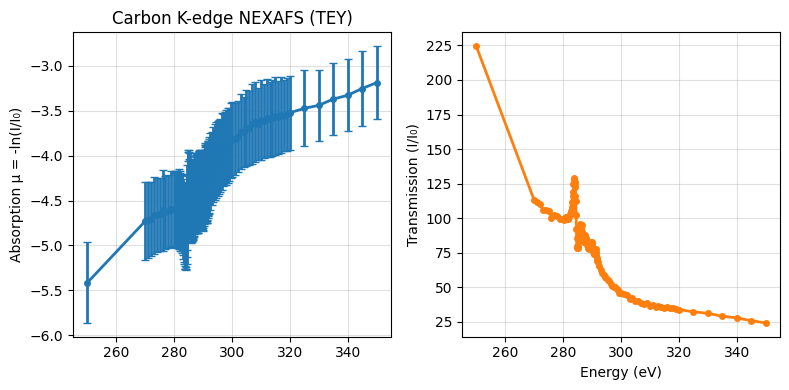

In [ ]:
# Calculate NEXAFS from the existing scan_data
nexafs_data = calculate_nexafs(
    scan_data, signal_channel="Photodiode", normalization_channel="AI 3 Izero"
)
plot_nexafs(nexafs_data, title="Carbon K-edge NEXAFS (TEY)")

In [42]:
hopg_results = await scan_motor_from_list(
    server=rsoxs,
    motor="Beamline Energy",
    positions=default_energies,  # First 10 energies for testing
    count_time_s=1.0,
    delay_after_move_s=0.2,
)

Scanning Beamline Energy:   0%|          | 0/157 [00:00<?, ?pos/s]

<Axes: xlabel='Beamline Energy_position'>

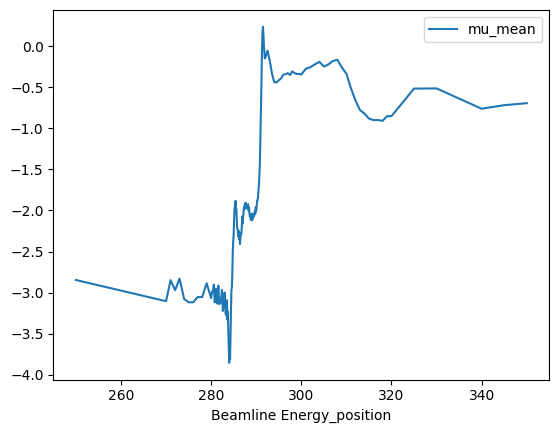

In [49]:
hopg_results["transmission_mean"] = (
    hopg_results["TEY signal_mean"] / hopg_results["AI 3 Izero_mean"]
)
hopg_results["mu_mean"] = np.log(hopg_results["transmission_mean"])
hopg_results.plot(x="Beamline Energy_position", y="mu_mean")

In [60]:
r = await rsoxs.get_motor(motors=["Sample Theta", "Sample Z"])
r

{'success': True,
 'error description': 'no error',
 'log?': False,
 'not found': [],
 'data': [{'motor': 'Sample Theta',
   'position': 0.0,
   'position_raw': 0.0,
   'goal': 0.0,
   'goal_raw': 0.0,
   'status': 65568,
   'time': 3843797935.9702},
  {'motor': 'Sample Z',
   'position': -2.9,
   'position_raw': 5800.0,
   'goal': -2.9,
   'goal_raw': 5800.0,
   'status': 67616,
   'time': 3843797935.9702}],
 'API_delta_t': 0.009682178497314453}

In [61]:
# Now let's move to Sample Theta 0, and Sample Z job by -5 for a better izero
await rsoxs.command_motor(
    commands=["Backlash Move"], motors=["Sample Theta"], goals=[0]
)
await rsoxs.command_motor(commands=["Backlash Move"], motors=["Sample Z"], goals=[-5])

_ = await wait_for_motor_completion(rsoxs, "Sample Theta", 30)
_ = await wait_for_motor_completion(rsoxs, "Sample Z", 30)

In [64]:
izero = await scan_motor_from_list(
    server=rsoxs,
    motor="Beamline Energy",
    positions=default_energies,  # First 10 energies for testing
    count_time_s=1.0,
    delay_after_move_s=0.2,
)

Scanning Beamline Energy:   0%|          | 0/157 [00:00<?, ?pos/s]

<Axes: xlabel='Beamline Energy_position'>

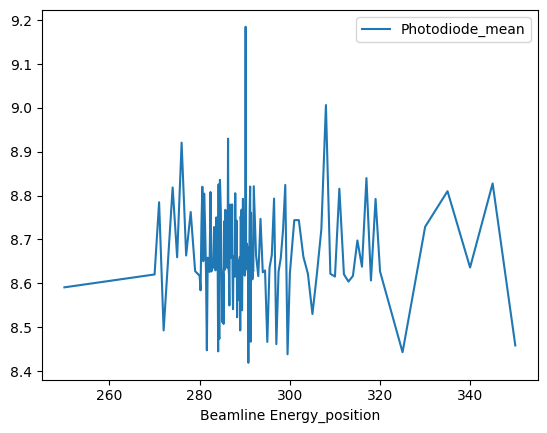

In [ ]:
izero.plot(x="Beamline Energy_position", y="Photodiode_mean")
# ????????????